ARIMA MODEL FOR AMZN STOCK PREDICTION¶
Time Series Analysis
Any data that collectively represents how a system/process/behaviour changes over time is known as Time Series data. Time series forecasting uses information regarding historical values and associated patterns to predict future activity. In this project, we are going to predict tomorrow's closing price of Amazon Stock (AMZN) by analysing the stock data for over a time period(3 years) until today. Predicting the performance of stock market is one of the most difficult tasks as the share prices are highly volatile for various reasons. Thus, forecasting prices with high accuracy rates is is difficult. ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values.

ARIMA
ARIMA (Auto-Regressive Integrated Moving Average) is a technique for modelling time series data for forecasting or predicting the future data points in the series by taking into consideration the following parameters:

Pattern or trend of growth/decline
Rate of change of growth/decline
Noise between consecutive data points

In [1]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PrettyTable

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
import pandas_datareader.data as web
import datetime as dt
from datetime import date, timedelta
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import *
from matplotlib import style
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
from prettytable import PrettyTable
rcParams['figure.figsize'] = 16,8

Reading Data¶
Data is pulled from Yahoo Finance with start date as 1/1/2016 and end date as current date so as to take into consideration the most recent trend for better predictions

In [4]:
start = dt.datetime(2016,1,1)
end = dt.datetime.today()

In [5]:
style.use('ggplot')

In [6]:
df = web.DataReader('AMZN', 'yahoo', start, end)

In [7]:
df.to_csv('AAPL.csv')
df = pd.read_csv('AAPL.csv', parse_dates = True, index_col = 0)

In [8]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,989.000000,989.000000,989.000000,989.000000,9.890000e+02,989.000000
mean,1277.537169,1252.634965,1266.323610,1265.713044,4.306027e+06,1265.713044
std,476.980633,466.889555,472.668375,472.003978,2.186812e+06,472.003978
min,493.500000,474.000000,478.010010,482.070007,1.458800e+06,482.070007
25%,819.419983,809.000000,814.320007,817.140015,2.825000e+06,817.140015
50%,1186.839966,1167.829956,1179.030029,1177.619995,3.677200e+06,1177.619995
75%,1755.599976,1719.229980,1742.140015,1739.489990,5.083900e+06,1739.489990
max,2050.500000,2013.000000,2038.109985,2039.510010,1.656500e+07,2039.510010


Feature Description
The data pulled from Yahoo Finance is stored in a .csv file. The AMZN stock data has the following features:

Date - in format: yyyy-mm-dd
High - Highest price reached in the day
Low - Lowest price reached in the day
Open - price of the stock at market open
Close - price of the stock at market close
Volume - Number of shares traded
Adj Close - stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time before the next day's ope

In [9]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990
2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978
2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024
2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002
2016-01-08,624.140015,606.000000,619.659973,607.049988,5512900,607.049988


In [10]:
group = df.groupby('Date')
Daily_ClosePrice = group['Close'].mean()

Daily_ClosePrice.head()

Date
2016-01-04    636.989990
2016-01-05    633.789978
2016-01-06    632.650024
2016-01-07    607.940002
2016-01-08    607.049988
Name: Close, dtype: float64

In [11]:
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-29,1824.689941,1800.790039,1817.780029,1800.800049,1923400,1800.800049
2019-12-02,1805.550049,1762.680054,1804.400024,1781.599976,3925600,1781.599976
2019-12-03,1772.869995,1747.229980,1760.000000,1769.959961,3380900,1769.959961
2019-12-04,1789.089966,1760.219971,1774.010010,1760.689941,2670100,1760.689941
2019-12-05,1763.500000,1740.000000,1763.500000,1740.479980,2827852,1740.479980


In [12]:
# indexing the dataframe by Date
df['Date'] = df.index

In [13]:
# convert the date column into a time series with daily frequency

df['Date'] = pd.to_datetime(df['Date'])

In [14]:
indexed_df = df.set_index('Date')

In [15]:
ts = indexed_df['Adj Close']
ts.head()

Date
2016-01-04    636.989990
2016-01-05    633.789978
2016-01-06    632.650024
2016-01-07    607.940002
2016-01-08    607.049988
Name: Adj Close, dtype: float64

C:\Users\kandukuri.s\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Adjusted Close Price')

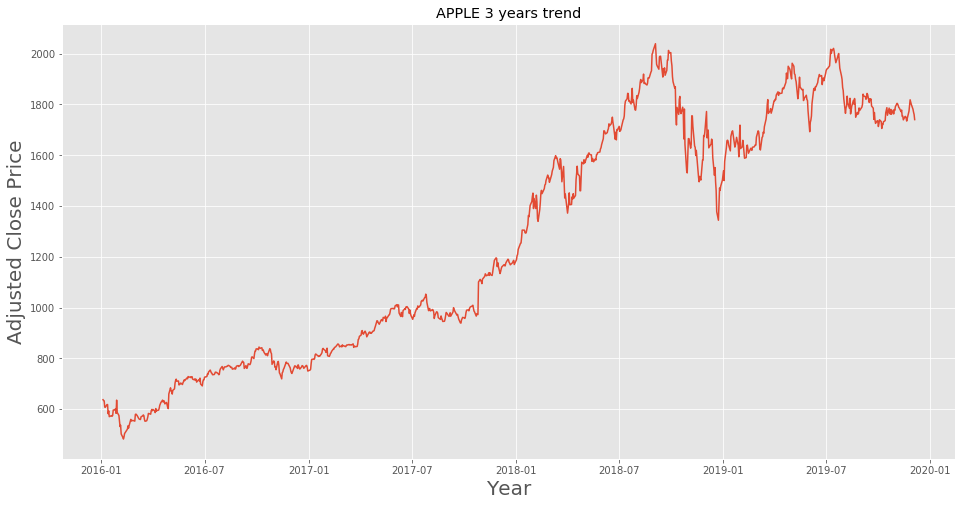

In [16]:
# visualize the time series to see how AMZN stock Close price trends over time
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title('APPLE 3 years trend')
plt.xlabel('Year',fontsize=20)
plt.ylabel('Adjusted Close Price',fontsize=20)

In [17]:
# resampling by week

ts_week = ts.resample('W').mean()
ts_week

Date
2016-01-10     623.683997
2016-01-17     596.123999
2016-01-24     579.412506
2016-01-31     600.695996
2016-02-07     539.273999
                 ...     
2019-11-10    1795.243994
2019-11-17    1759.369995
2019-11-24    1746.256006
2019-12-01    1797.522491
2019-12-08    1763.182465
Freq: W-SUN, Name: Adj Close, Length: 205, dtype: float64

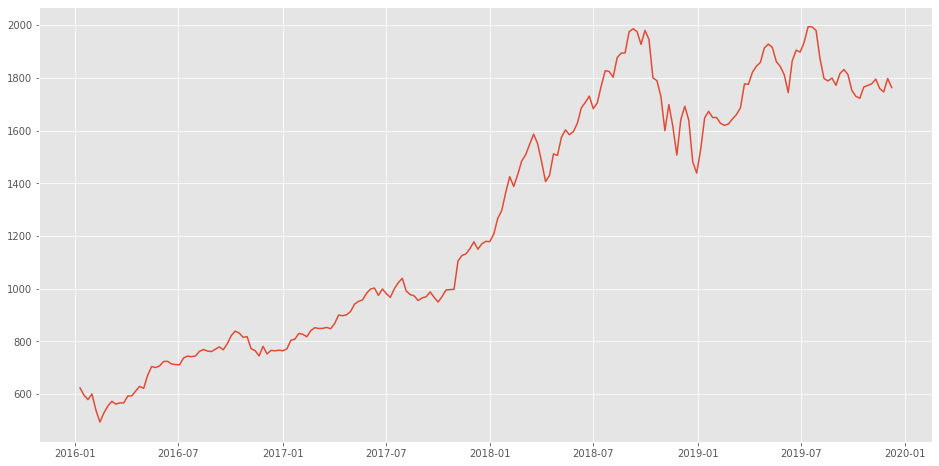

In [18]:
plt.figure(figsize=(16,8))
plt.plot(ts_week)

Check for Stationarity of the Time series
Stationary Time Series data does not have any upward or downward trend or seasonal effects. Mean or variance are consistent over time

Non-Stationary Time Series data show trends, seasonal effects, and other structures depend on time. Forecasting performance is dependent on the time of observation. Mean and variance change over time and a drift in the model is captured.

We are using a statistical method called Dickey-Fuller test to check if our time series is stationary or not.

In [19]:
# check for stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries, color='green',label='APPLE Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Time(Days)',fontsize=15)
    plt.ylabel('$(Dollar)',fontsize=15)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

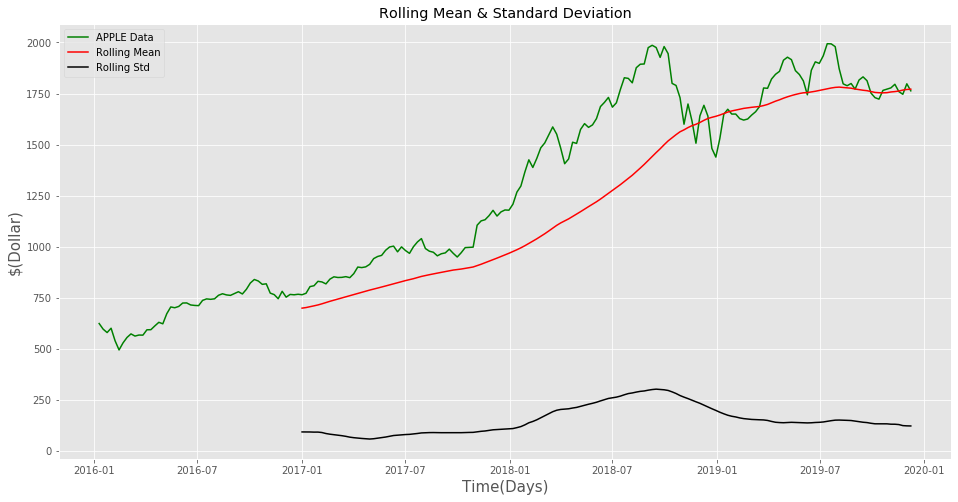

Results of Dickey-Fuller Test:
Test Statistic                  -1.212607
p-value                          0.668149
#Lags Used                       4.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [20]:
test_stationarity(ts_week)

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary. Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

In [21]:
# apply a non linear log transform

ts_week_log = np.log(ts_week)

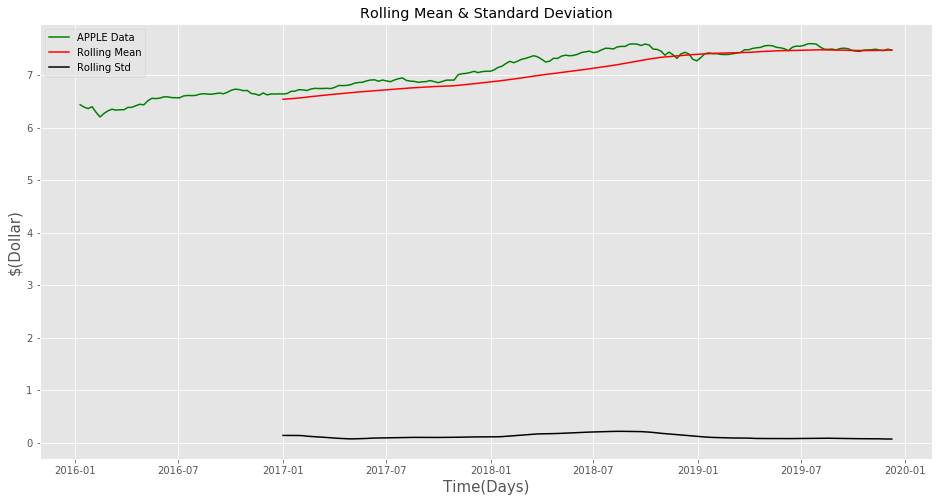

Results of Dickey-Fuller Test:
Test Statistic                  -1.522105
p-value                          0.522550
#Lags Used                       2.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


In [22]:
test_stationarity(ts_week_log)

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05

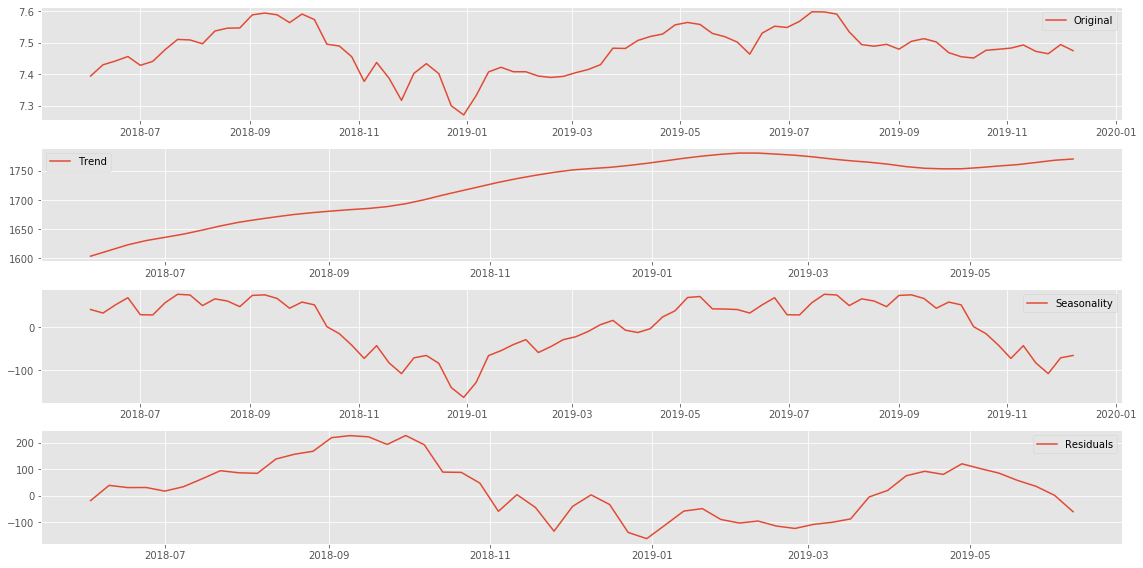

In [23]:
# remove trend and seasonality with decomposition

decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(ts_week_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Time series are stationary if they do not have trend or seasonal effects. We are going to use the difference transform to remove the time series' dependence on time.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Seasonality')

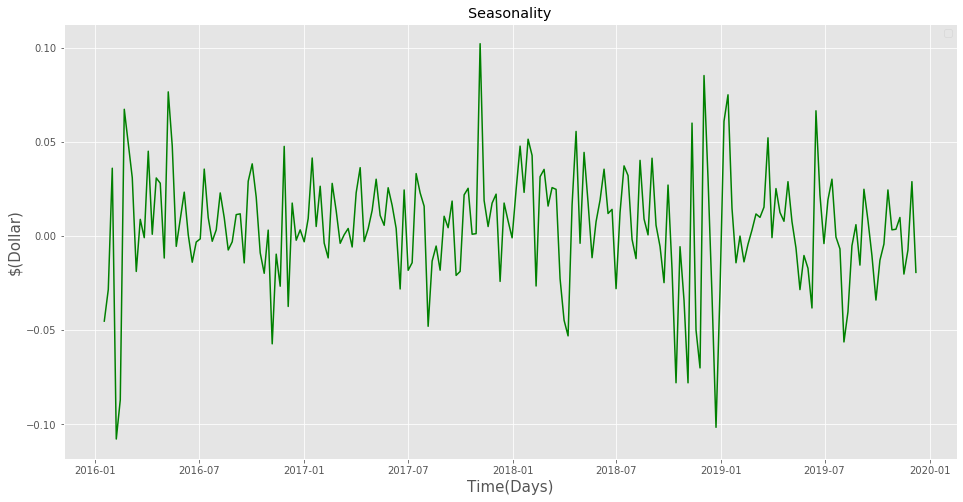

In [24]:
# remove trend and seasonality with differencing
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.figure(figsize=(16,8))
plt.plot(ts_week_log_diff,color='green')
plt.legend(loc='best')
plt.xlabel('Time(Days)',fontsize=15)
plt.ylabel('$(Dollar)',fontsize=15)
plt.title('Seasonality')

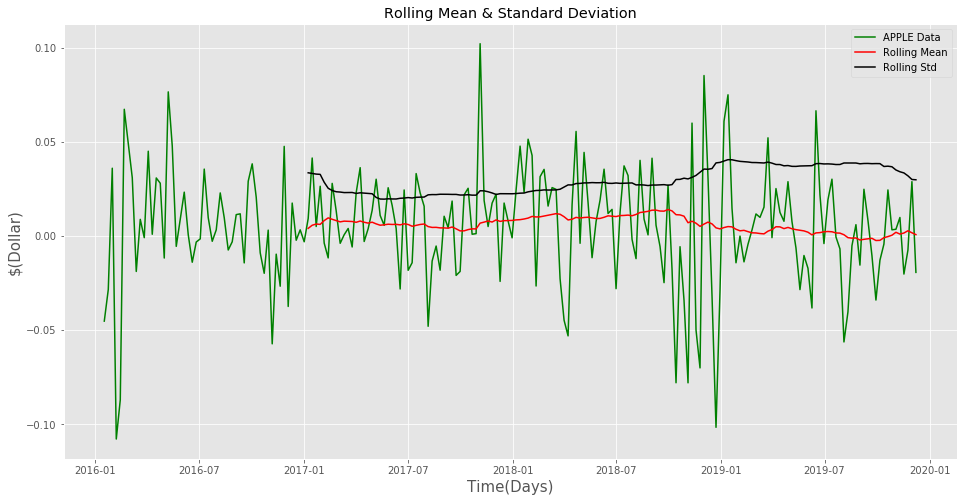

Results of Dickey-Fuller Test:
Test Statistic                -7.732383e+00
p-value                        1.116491e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


In [25]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

The above graph shows how the rolling mean and rolling standard deviation are comparitively consistent over time after the time series transformation. We can proceed to use this transformed data for training our ARIMA model and forecasting the upcoming week's stock price.
ARIMA Model
An ARIMA model is usually stated as ARIMA(p,d,q). This represents the order of the autoregressive components (p), the number of differencing operators (d), and the highest order of the moving average term. For example, ARIMA(2,1,1) means that you have a second order autoregressive model with a first order moving average component whose series has been differenced once to induce stationarity.

In [26]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=2010.895431, expected=1945.500024
predicted=1946.984123, expected=1799.591992
predicted=1801.226659, expected=1789.477979
predicted=1822.126308, expected=1729.436011
predicted=1728.313014, expected=1599.674023
predicted=1594.971045, expected=1698.688037
predicted=1736.670376, expected=1615.976001
predicted=1599.739464, expected=1506.635010
predicted=1526.679378, expected=1640.847998
predicted=1662.850154, expected=1692.269989
predicted=1682.834652, expected=1639.620020
predicted=1652.959755, expected=1481.149976
predicted=1472.202497, expected=1438.630005
predicted=1465.185832, expected=1529.192505


C:\Users\kandukuri.s\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1542.192675, expected=1648.458008
predicted=1658.551621, expected=1672.993994
predicted=1668.785022, expected=1649.422516
predicted=1658.937456, expected=1649.432007
predicted=1663.326143, expected=1626.994019
predicted=1630.946275, expected=1619.921997
predicted=1634.229020, expected=1625.169983
predicted=1634.146307, expected=1644.409985
predicted=1656.911264, expected=1660.860010
predicted=1669.256205, expected=1686.621997
predicted=1699.463662, expected=1777.060010
predicted=1799.219788, expected=1775.578003
predicted=1767.620780, expected=1821.001978
predicted=1850.599511, expected=1844.031982
predicted=1843.787747, expected=1858.604980
predicted=1875.808136, expected=1913.142017
predicted=1929.195869, expected=1927.950000
predicted=1933.832922, expected=1915.834009
predicted=1927.690295, expected=1862.104004
predicted=1865.709798, expected=1842.986011
predicted=1861.240300, expected=1811.752472
predicted=1814.348622, expected=1743.828003
predicted=1748.545811, expected=

In [27]:
predictions_series = pd.Series(predictions, index = test.index)

<Figure size 1152x576 with 0 Axes>

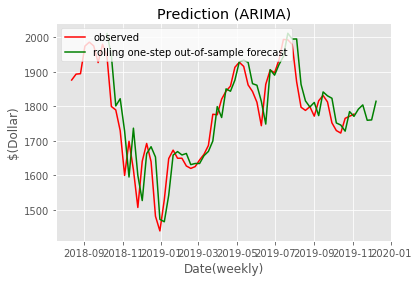

In [28]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot(ts_week[-70:-5], label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [29]:
r2

0.7501041497465784

Tuning hyper parameters for our ARIMA model
We are implementing grid search to find the best combination of p, d, q values for our model

In [30]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

order=(2,1,1)
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, (order))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    #print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(ts_week_log, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=3.705
ARIMA(0, 1, 1) RMSE=0.032
ARIMA(0, 1, 2) RMSE=0.032
ARIMA(0, 1, 3) RMSE=0.032
ARIMA(0, 1, 4) RMSE=0.033
ARIMA(0, 2, 1) RMSE=0.034
ARIMA(1, 0, 0) RMSE=0.033
ARIMA(1, 1, 0) RMSE=0.033
ARIMA(1, 2, 0) RMSE=0.041
ARIMA(1, 2, 2) RMSE=0.032
ARIMA(1, 2, 3) RMSE=0.033
ARIMA(2, 1, 0) RMSE=0.032
ARIMA(2, 1, 1) RMSE=0.032
ARIMA(2, 2, 0) RMSE=0.036
ARIMA(2, 2, 1) RMSE=0.034
ARIMA(2, 2, 2) RMSE=0.032
ARIMA(2, 2, 3) RMSE=0.035
ARIMA(3, 0, 0) RMSE=0.032
ARIMA(3, 1, 0) RMSE=0.032
ARIMA(3, 1, 1) RMSE=0.033
ARIMA(3, 1, 2) RMSE=0.035
ARIMA(3, 2, 0) RMSE=0.037
ARIMA(3, 2, 1) RMSE=0.032
ARIMA(4, 0, 0) RMSE=0.033
ARIMA(4, 1, 0) RMSE=0.033
ARIMA(4, 1, 1) RMSE=0.033
ARIMA(4, 1, 2) RMSE=0.034
ARIMA(4, 1, 3) RMSE=0.033
ARIMA(4, 2, 0) RMSE=0.036
ARIMA(4, 2, 1) RMSE=0.034


The combination of p,d,q values for which the RMSE is lowest is chosen as the best combination. In our case, there are multiple combinations with least RMSE of 0.032 and we will be comparing the accuracy of the corresponding model, to find the best one.¶
1. Order = (3,2,1),(3,1,0),(3,0,0),(2,2,2),(2,1,1),(2,1,0),(1,2,2),(0,1,3),(0,1,2),(0,1,1)



In [35]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [39]:



# Define the d and q parameters to take any value between 0 and 1
q  = range(0, 2)
d = range(0,2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [72]:
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [42]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(3,2,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7401666472176125


Printing Mean Squared Error of Predictions...
Test MSE: 0.001312


In [73]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.740931983525712


Printing Mean Squared Error of Predictions...
Test MSE: 0.001309


Accuracy for Order = (3,2,1) is 74.01%¶
2. Order = (3,1,0)

In [44]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7469653382697476


Printing Mean Squared Error of Predictions...
Test MSE: 0.001278


Accuracy for Order = (3,1,0) is 74.69%¶

Order = (3,0,0)

In [45]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,0)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7413564710225364


Printing Mean Squared Error of Predictions...
Test MSE: 0.001306


Accuracy for Order = (3,0,0) is 74.13%¶

Order = (2,2,2)

In [46]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,2,2)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7433912911949829


Printing Mean Squared Error of Predictions...
Test MSE: 0.001296


Accuracy for Order = (2,2,2) is 74.33%¶

Order = (2,1,1)

In [47]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7501041497465784


Printing Mean Squared Error of Predictions...
Test MSE: 0.001262


Accuracy for Order = (2,1,1) is 75.01%¶

Order = (2,1,0)

In [48]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7462022032949133


Printing Mean Squared Error of Predictions...
Test MSE: 0.001282


Accuracy for Order = (2,1,0) is 74.62%¶

Order = (1,2,2)

In [50]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,2)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7493390034993161


Printing Mean Squared Error of Predictions...
Test MSE: 0.001266


Accuracy for Order = (2,1,0) is 74.93%¶

Order = (0,1,3)

In [51]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,3)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.7515566077372404


Printing Mean Squared Error of Predictions...
Test MSE: 0.001255


Accuracy for Order = (0,1,3) is 75.15%¶

Order = (0,1,2)

In [58]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()
#result = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,2)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast(14)[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
       
    #result=pd.DataFrame(index = yhat, data={'predictions': yhat, 'actual': obs})
    #result.to_csv('Results.csv')
    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=2010.628538, expected=1945.500024
predicted=1947.842068, expected=1799.591992
predicted=1799.447912, expected=1789.477979
predicted=1819.448383, expected=1729.436011
predicted=1728.722481, expected=1599.674023
predicted=1594.268217, expected=1698.688037
predicted=1744.361505, expected=1615.976001
predicted=1603.962479, expected=1506.635010
predicted=1514.984535, expected=1640.847998
predicted=1685.867441, expected=1692.269989
predicted=1683.121939, expected=1639.620020
predicted=1642.608076, expected=1481.149976
predicted=1470.899769, expected=1438.630005
predicted=1466.588500, expected=1529.192505
predicted=1555.290178, expected=1648.458008
predicted=1663.846880, expected=1672.993994
predicted=1666.260367, expected=1649.422516
predicted=1654.792105, expected=1649.432007
predicted=1661.904782, expected=1626.994019
predicted=1631.418263, expected=1619.921997
predicted=1634.330113, expected=1625.169983
predicted=1635.421369, expected=1

Accuracy for Order = (0,1,2) is 75.15%¶

Order = (0,1,1)

In [56]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=5)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.741155283660418


Printing Mean Squared Error of Predictions...
Test MSE: 0.001307


Accuracy for Order = (0,1,1) is 74.11%¶


In [59]:
predictions_series = pd.Series(predictions, index = test.index)

<Figure size 1152x576 with 0 Axes>

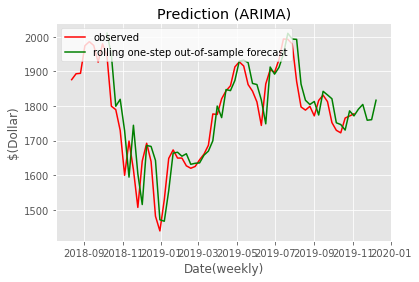

In [60]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot(ts_week[-70:-5], label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [61]:
np.exp(predictions_series)

Date
2018-10-07    2010.628538
2018-10-14    1947.842068
2018-10-21    1799.447912
2018-10-28    1819.448383
2018-11-04    1728.722481
                 ...     
2019-11-10    1790.826492
2019-11-17    1804.641530
2019-11-24    1758.918309
2019-12-01    1760.550440
2019-12-08    1816.773444
Freq: W-SUN, Length: 62, dtype: float64

Accuracy for Order = (0,1,2) = 79.49%

Observations
The above graph represents the comparison of our observed stock close prices vs forecasted close price for the upcoming week with an accuracy of 79.49%

Results of Grid Search to tune hyper parameters:


Comparison of the predicted values vs expected values

Conclusion
Predicting stock market prices is really a difficult task, as the market keeps changing continuously with time following a trend based on various factors.
All Stock market data are a time series problem and we have analysed and transformed our Amazon stock price data treating its seasonality and trend as these affect the prediction.
We have modelled a ML algorithm called ARIMA(Auto-Regressive Integrated Moving Average) to forecast the stock market prices and tuned the hyper parameters to get a model that predicts with better accuracy.
We would be comparing our model with the performance of FB prophet after tuning to check for the better mode

In [62]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990,2016-01-04
2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978,2016-01-05
2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024,2016-01-06
2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002,2016-01-07
2016-01-08,624.140015,606.000000,619.659973,607.049988,5512900,607.049988,2016-01-08


In [70]:
def GARCH_t(Y):
    "initilize parameters"
    
    mu=param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    nv = param0[4]
    T = Y.shape[0]
    GARCH_t = np.zeros(T)
    sigma2 = np.zeros(T)
    F= np.zeros(T)
    v= np.zeros(T)
    
    for t in range (1,T):
        
            sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
            F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.standard_t(nv,1)
            v[t] = sigma2[t]
            GARCH_t[t] = np.log(ss.gamma((nv+1)/2))- np.log(np.sqrt(nv*np.pi))- np.log(ss.gamma(nv/2))-((nv+1)/2)*np.log(1+((F[t]**2)/v[t])/nv)
            Likelihood= np.sum(GARCH_t[1:-1])
            return Likelihood
        
        
        

In [69]:
def GARCH_PROD_t(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    nv = params[4]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.standard_t(nv,1)
        return Y

In [76]:
def Kalman_Filter(Y):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = param0[0]
 T = param0[1]
 H = param0[2]
 Q = param0[3]
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 KF_Dens = np.zeros(S)
 for s in range(1,S):
  if s == 1:
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q
  else:
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H
    v[s]=Y[s-1]-Z*u_predict[s-1]
    u_update[s] = u_predict[s-1] + P_predict[s-1] * np.transpose(Z)(1/F[s])*v[s]
    u_predict[s] = T*u_update[s];
    P_update[s] = P_predict[s-1]-P_predict[s-1] * np.transpose(Z)(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2) * np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])(1/F[s])*v[s]
    Likelihood = np.sum(KF_Dens[1:-1])
   
    return Likelihood

In [78]:
def Kalman_Smoother(params, Y):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]

 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1:
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q
   else:
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H
    v[s]=Y[s-1]-Z*u_predict[s-1]
    u_update[s] = u_predict[s-1]+P_predict[s-1] * np.transpose(Z)(1/F[s])*v[s]
    u_predict[s] = T*u_update[s];
    P_update[s] = P_predict[s-1]-P_predict[s-1] * np.transpose(Z)(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q

    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]
    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t] * np.transpose(T)/P_predict[t](u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t] * np.transpose(T)/P_predict[t](P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[0:-1]
 return u_smooth


In [85]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize

In [86]:
def rmse_calc(actual, predicted):
    sum_error = 0.0
    for i in range(Y.shape[0]):
        prediction_error = predicted[i] - actual[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(Y.shape[0])
    return np.sqrt(mean_error)



B = df['Close']
A = df['Open']
C = df['High']
D = df['Low']

Y = B
T = Y.shape[0]

param0 = np.array([1, 0.45, 10*np.var(Y), 300*np.var(Y)])
param_star = minimize(Kalman_Filter, param0, method='BFGS',options={'gtol': 1e-8, 'disp': False})
Y_update = Kalman_Smoother(param_star.x, Y)
timevec = df[1:]['Date']
plt.plot(timevec, Y_update[1:],'r',timevec, Y[1:],'b:')
print(rmse_calc(Y,Y_update))

TypeError: 'numpy.float64' object is not callable